In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.transforms import Bbox
from matplotlib.ticker import FuncFormatter
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.colorbar import make_axes
import mpl_extra.treemap as tr
import matplotlib as mpl
import os



In [ ]:

# downloading the informations about the companies
def download_info():
    company_info = pd.DataFrame(columns=['Symbol','Company','EV','SharesOutstanding','Price', 'PriceChange','Sector', 'Industry'])
    for index, row in df.iterrows():
    # Retrieve information for the top 1000 companies
        
        ticker = yfin.Ticker(row.Symbol)

    
        # Loop through each company and retrieve the requested information
        try:
            info = ticker.info
            sector = info['sector']
            industry = info['industry']
            enterprise_value = info['enterpriseValue']
            shares_outstanding = info['sharesOutstanding']
            price = ticker.history(period='1d')['Close'][0]
            #compute procentual price change from previous close and actual close
            price_change = (price - info['previousClose']) / info['previousClose'] * 100  
            company_info = company_info.append({'Company': info['longName'], 'EV': enterprise_value, 
                            'SharesOutstanding': shares_outstanding, 'Price': price, 'Symbol': row.Symbol,
                            'PriceChange': price_change, 'Sector': sector,
                            'Industry': industry}, ignore_index=True)
        # catch exception and print it
        except Exception as e:
            print(e)
            print('No information for ticker: ', row.Symbol)
            continue
    return company_info
    #save the data to a csv file
def save_info(df):
    df.to_csv('company_info.csv', index=False)


In [22]:

#if doesnt file exists, download the data
if not os.path.exists('company_info.csv'):
    company_info = download_info()
    save_info(company_info)
#load data from csv to dataframe
company_info = pd.read_csv('company_info.csv')


In [21]:
#returns color based on the value, if value is negative, it returns red, if positive green, if 0 blue shades
def get_color(val):
    if val < 0:
        #return textcolor
        return plt.cm.Reds(np.abs(val)/3)
    elif val > 0:
        return plt.cm.Greens(val/3)
    else:
        return plt.cm.Blues(0.5)

In [23]:


#get unique values of sector in alphabetical order
sectors = company_info['Sector'].unique()
secotrs = sectors.sort()

#filter sectors
sectors = sectors[:2]

#filter sectors
company_info = company_info[company_info['Sector'].isin(sectors)]
# Create a treemap for top categories

company_info['EV_change'] = company_info['EV'] * company_info['PriceChange']
company_info['labels'] = company_info['Symbol'] + '\n' + round(company_info['PriceChange'],2).astype(str) + '%'

top_category_values = company_info.groupby('Sector')['EV_change', 'EV'].sum().reset_index()
top_category_values['PriceChange'] = top_category_values['EV_change'] / top_category_values['EV']

total_EV = top_category_values['EV'].sum()

#set minimum price change to -10 and maximum to 10
company_info['PriceChange'] = company_info['PriceChange'].clip(-100,100)
#normalize price change to 0-1
company_info['PriceChangeNormalized'] = (company_info['PriceChange'] + 100) / 200


colors = [get_color(val) for val in company_info['PriceChange']]
#transform colors to hex
company_info['colors'] = colors

#sort by pricechangenormalized
company_info = company_info.sort_values(by='PriceChangeNormalized', ascending=False)

/tmp/ipykernel_427259/1872427118.py:15: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  top_category_values = company_info.groupby('Sector')['EV_change', 'EV'].sum().reset_index()


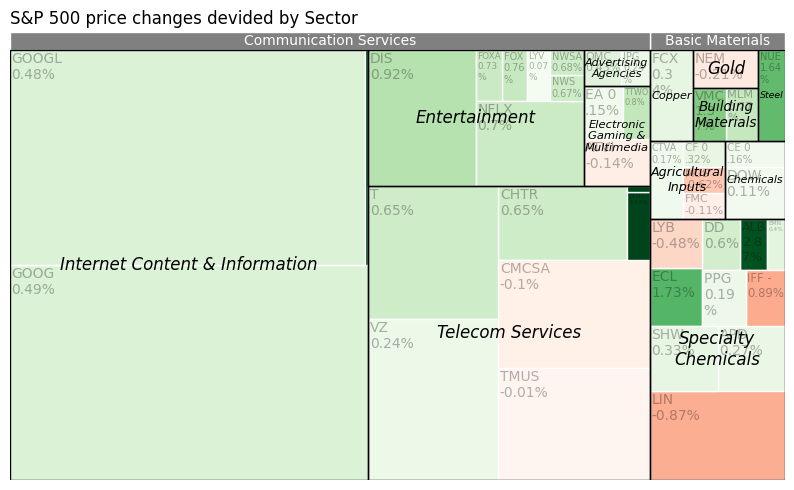

In [24]:
fig, ax = plt.subplots(figsize=(10,6), dpi=100, subplot_kw=dict(aspect=1.156))

trc = tr.treemap(
    ax, company_info, area='EV', fill='colors', labels='labels', norm_y=50,
    levels=['Sector', 'Industry', 'Symbol'],  split=False,
    rectprops=dict(ec='w'),
    textprops=dict(c='k', reflow=True, place='top left', alpha=0.3,max_fontsize=10),
    subgroup_rectprops=dict(
                            #Industry={'pad':(0,0,2,0)},
                            Sector={'ec':'w', 'fc':'grey',},
                            Industry = {'ec':'black', 'fc':'grey', 'zorder':2,'fill':False, 'pad':(0,0,2,0)},
                            # Symbol={'pad':(0,0,2,0), 'color':}
                            ),
    subgroup_textprops=dict(
                                Sector={'place':'top center', 'max_fontsize':10,'color':'w'},
                                Industry={'reflow':True,'place':'center center', 'max_fontsize':12, 'alpha':1, 'fontstyle':'italic'},
                            )
)

#add to each rectangle little lines showing subcategories

ax.set_title('S&P 500 price changes devided by Sector', x=0, ha='left')

fig.savefig('total_overview.png', dpi='figure', bbox_inches='tight')

plt.axis('off')
plt.show()



/tmp/ipykernel_427259/3227536907.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info_sub['EV_change'] = company_info_sub['EV'] * company_info_sub['PriceChange']


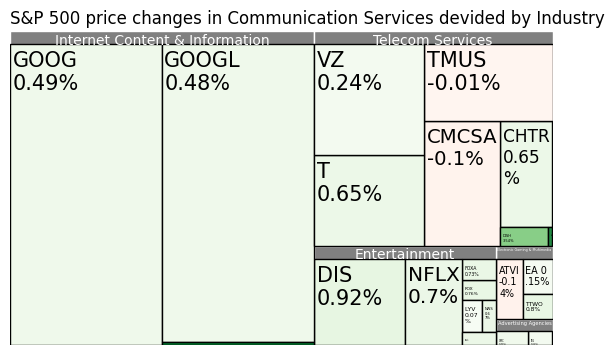

In [11]:
# Create a treemap for subcategories
company_info_sub = company_info[company_info['Sector'] == 'Communication Services']
company_info_sub['EV_change'] = company_info_sub['EV'] * company_info_sub['PriceChange']

fig, ax = plt.subplots(figsize=(7,7), dpi=100, subplot_kw=dict(aspect=1.156))


trc = tr.treemap(
    ax, company_info_sub, area='EV', levels=['Industry', 'Symbol'], norm_y=50, top=True,
    fill='colors', labels='labels', split=False,
    cmap=colors,
    rectprops=dict(ec='k', pad=(0,0,0,2), zorder=2),
    textprops=dict(reflow=True, place='top left', grow=True,
                  max_fontsize=15, color='k', pady=4, padx=2),
    subgroup_rectprops={'Industry':dict(ec='w', fc='grey', pad=(0,0,0,2))},
    subgroup_textprops={'Industry':dict(place='top center', max_fontsize=10, 
                                   c='w')},
)


fig.savefig('total_overview.png', dpi='figure', bbox_inches='tight')

ax.set_title('S&P 500 price changes in Communication Services devided by Industry', x=0, ha='left')

ax.axis('off')
#set font size to labels
plt.show()

/tmp/ipykernel_427259/2345922382.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_info_sub_sub['labels'] = company_info_sub_sub['Company'] + '\n\nPrice Change:'+ round(company_info_sub_sub['PriceChange'],2).astype(str) + ' %\n'+'Price: $' + round(company_info_sub_sub['Price'],2).astype(str) + '\nEV: $' + round(company_info_sub_sub['EV']/1000000000,2).astype(str) + ' bil\nShares: ' + (round(company_info_sub_sub['SharesOutstanding']/1000000, 0)).astype(str) + ' mln'


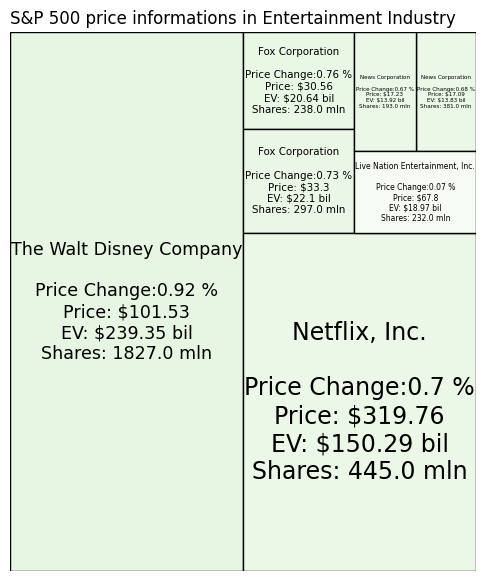

In [7]:

fig, ax = plt.subplots(figsize=(7,7), dpi=100, subplot_kw=dict(aspect=1.156))

# filter rows for Technology and Computer Hardware
company_info_sub_sub = company_info[company_info['Industry'] == 'Entertainment']
#set bigger font size

company_info_sub_sub['labels'] = company_info_sub_sub['Company'] + '\n\nPrice Change:'+ round(company_info_sub_sub['PriceChange'],2).astype(str) + ' %\n'+'Price: $' + round(company_info_sub_sub['Price'],2).astype(str) + '\nEV: $' + round(company_info_sub_sub['EV']/1000000000,2).astype(str) + ' bil\nShares: ' + (round(company_info_sub_sub['SharesOutstanding']/1000000, 0)).astype(str) + ' mln'

tr.treemap(ax, company_info_sub_sub, area='EV', labels='labels', 
           fill='colors',
           rectprops=dict(ec='k'),
           textprops=dict(c='black'))
ax.set_title('S&P 500 price informations in Entertainment Industry', x=0, ha='left')

plt.axis('off')
plt.show()